# Imports

In [1]:
# for data analysis
import numpy as np
import pandas as pd

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for outlier capping
from scipy.stats.mstats import winsorize

# for text pattern matching
import re

# Initial Look

In [2]:
# import dataset
cost_of_living = pd.read_csv("C:/Users/barbe/OneDrive/DS Projects/Cost of Living Prediction/cost_of_living_us.csv")

In [3]:
# check first few rows
cost_of_living.head()

,case_id,state,isMetro,areaname,county,family_member_count,housing_cost,food_cost,transportation_cost,healthcare_cost,other_necessities_cost,childcare_cost,taxes,total_cost,median_family_income
0,1,AL,True,"Montgomery, AL MSA",Autauga County,1p0c,8505.72876,3454.91712,10829.16876,5737.47984,4333.81344,0.0000,6392.94504,39254.0532,73010.414062
1,1,AL,True,"Montgomery, AL MSA",Autauga County,1p1c,12067.50240,5091.70788,11588.19288,8659.55640,6217.45896,6147.8298,7422.07836,57194.3256,73010.414062
2,1,AL,True,"Montgomery, AL MSA",Autauga County,1p2c,12067.50240,7460.20308,12361.77720,11581.63260,7075.65816,15824.6940,9769.56228,76141.0308,73010.414062
3,1,AL,True,"Montgomery, AL MSA",Autauga County,1p3c,15257.15040,9952.23924,13452.18600,14503.70760,9134.35620,18802.1892,13101.70320,94203.5328,73010.414062
4,1,AL,True,"Montgomery, AL MSA",Autauga County,1p4c,15257.15040,12182.21400,13744.59840,17425.78560,9942.36396,18802.1892,13469.21880,100823.5200,73010.414062


Looking at the first few instances, we can see some items of note:
- Don't like how family member count is set up. Could split to have parent, child, and total as integer. Will investigate and consider further.
- Costs look like they're on similar scale, but some values are much higher/lower than others. May need to scale for modeling.
- case_id and areaname are basically saying the same thing

In [4]:
# check shape of the dataste
cost_of_living.shape

(31430, 15)

There are 31430 instances and 15 variables. The variables consist of:
- case_id: unique identifier for each areaname
- state: the state where the county is located
- isMetro: indicates whether the county is part of a metropolitan area
- areaname: the areaname for the location
- county: name of the county
- family_member_count: number of memebers in the household where p is parent and c is child
- housing_cost: estimated annual cost of housing for the family type in the county
- food_cost: estimated annual cost of food for the family type in the county
- transportation_cost: estimated annual cost of transportation for the family type in the county
- healthcare_cost: estimated annual cost of healthcare for the family type in the county
- other_necessities_cost: estimated annual cost of other necessities for the family type in the county
- childcare_cost: estimated annual cost of childcare for the family type in the county
- taxes: estimated annual tax for the family type in the county
- total_cost: total estimated annual cost of living for the family type in the county
- median_family_income: median annual income for families in the county

# Data Cleaning

## Missing Values and Duplicates

In [5]:
# check missing values
print('Missing value count: \n', cost_of_living.isnull().sum())

# check for duplicates
print('\n Duplicate count: ', cost_of_living.duplicated().sum())

Missing value count: 
 case_id                    0
state                      0
isMetro                    0
areaname                   0
county                     0
family_member_count        0
housing_cost               0
food_cost                  0
transportation_cost        0
healthcare_cost            0
other_necessities_cost     0
childcare_cost             0
taxes                      0
total_cost                 0
median_family_income      10
dtype: int64

 Duplicate count:  0


No duplicates were found, but there are 10 instances where median_family_income is missing. Let's look at that further.

In [6]:
cost_of_living[cost_of_living['median_family_income'].isnull()]

,case_id,state,isMetro,areaname,county,family_member_count,housing_cost,food_cost,transportation_cost,healthcare_cost,other_necessities_cost,childcare_cost,taxes,total_cost,median_family_income
15110,1533,MO,True,"St. Louis, MO-IL HUD Metro FMR Area",Sullivan part,1p0c,8052.0,3019.16160,11086.4934,6505.34988,4011.51852,0.00000,6075.80856,38750.3316,NaN
15111,1533,MO,True,"St. Louis, MO-IL HUD Metro FMR Area",Sullivan part,1p1c,11256.0,4449.51084,11722.2708,9930.74856,5690.72604,7555.66332,7196.82420,57801.7440,NaN
15112,1533,MO,True,"St. Louis, MO-IL HUD Metro FMR Area",Sullivan part,1p2c,11256.0,6519.27612,12405.8652,13356.14640,6440.68356,14323.03800,8732.72244,73033.7340,NaN
15113,1533,MO,True,"St. Louis, MO-IL HUD Metro FMR Area",Sullivan part,1p3c,14688.0,8697.00216,12854.8620,16781.54400,8473.30884,16405.30800,11755.84356,89655.8676,NaN
15114,1533,MO,True,"St. Louis, MO-IL HUD Metro FMR Area",Sullivan part,1p4c,14688.0,10645.71900,13619.9388,20206.94280,9179.40600,16405.30800,12372.99120,97118.3088,NaN
15115,1533,MO,True,"St. Louis, MO-IL HUD Metro FMR Area",Sullivan part,2p0c,8772.0,5535.13032,12918.5988,13010.70000,5184.03768,0.00000,7023.17208,52443.6384,NaN
15116,1533,MO,True,"St. Louis, MO-IL HUD Metro FMR Area",Sullivan part,2p1c,11256.0,6889.02612,13557.9828,16436.09760,6574.65816,7555.66332,8939.94504,71209.3716,NaN
15117,1533,MO,True,"St. Louis, MO-IL HUD Metro FMR Area",Sullivan part,2p2c,11256.0,8724.80352,13977.7980,19861.49760,7239.83280,14323.03800,9841.96872,85224.9372,NaN
15118,1533,MO,True,"St. Louis, MO-IL HUD Metro FMR Area",Sullivan part,2p3c,14688.0,10652.32248,14798.7552,23286.89520,9181.79808,16405.30800,11854.97676,100868.0508,NaN
15119,1533,MO,True,"St. Louis, MO-IL HUD Metro FMR Area",Sullivan part,2p4c,14688.0,13035.88920,14802.7416,26712.29280,10045.45896,16405.30800,12050.91480,107740.6056,NaN


Note:
- The missing values come from sequential instances.
- All missing values are from the same area and county.

In [7]:
sullivan_count = cost_of_living[cost_of_living['county'] == "Sullivan part"].shape[0]
print(f"Number of instances where county is Sullivan part: {sullivan_count}")

Number of instances where county is Sullivan part: 10


Notice that all 10 instances with missing values all come from the county Sullivan part, in which there are only 10 instances from that county. Since it's only 10 instances out of 31430, they will be dropped.

In [8]:
# drop instances with missing values
cost_of_living = cost_of_living.dropna(subset=['median_family_income'])

#check for missing values
print('Missing value count: \n', cost_of_living.isnull().sum())

# check shape
print('\n', cost_of_living.shape)

Missing value count: 
 case_id                   0
state                     0
isMetro                   0
areaname                  0
county                    0
family_member_count       0
housing_cost              0
food_cost                 0
transportation_cost       0
healthcare_cost           0
other_necessities_cost    0
childcare_cost            0
taxes                     0
total_cost                0
median_family_income      0
dtype: int64

 (31420, 15)


## Data type and structure

In [9]:
cost_of_living.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31420 entries, 0 to 31429
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   case_id                 31420 non-null  int64  
 1   state                   31420 non-null  object 
 2   isMetro                 31420 non-null  bool   
 3   areaname                31420 non-null  object 
 4   county                  31420 non-null  object 
 5   family_member_count     31420 non-null  object 
 6   housing_cost            31420 non-null  float64
 7   food_cost               31420 non-null  float64
 8   transportation_cost     31420 non-null  float64
 9   healthcare_cost         31420 non-null  float64
 10  other_necessities_cost  31420 non-null  float64
 11  childcare_cost          31420 non-null  float64
 12  taxes                   31420 non-null  float64
 13  total_cost              31420 non-null  float64
 14  median_family_income    31420 non-null

- 10 variables are numerical
- 1 variable is boolean. The boolean can stay until we preprocess the data for modeling.
- 4 variables are object. The object variables are string-based, so let's change them into category type.

In [10]:
# Convert all object columns to category
for col in cost_of_living.select_dtypes(include=['object']).columns:
    cost_of_living[col] = cost_of_living[col].astype('category')

cost_of_living.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31420 entries, 0 to 31429
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   case_id                 31420 non-null  int64   
 1   state                   31420 non-null  category
 2   isMetro                 31420 non-null  bool    
 3   areaname                31420 non-null  category
 4   county                  31420 non-null  category
 5   family_member_count     31420 non-null  category
 6   housing_cost            31420 non-null  float64 
 7   food_cost               31420 non-null  float64 
 8   transportation_cost     31420 non-null  float64 
 9   healthcare_cost         31420 non-null  float64 
 10  other_necessities_cost  31420 non-null  float64 
 11  childcare_cost          31420 non-null  float64 
 12  taxes                   31420 non-null  float64 
 13  total_cost              31420 non-null  float64 
 14  median_family_income  

## Outlier Analysis

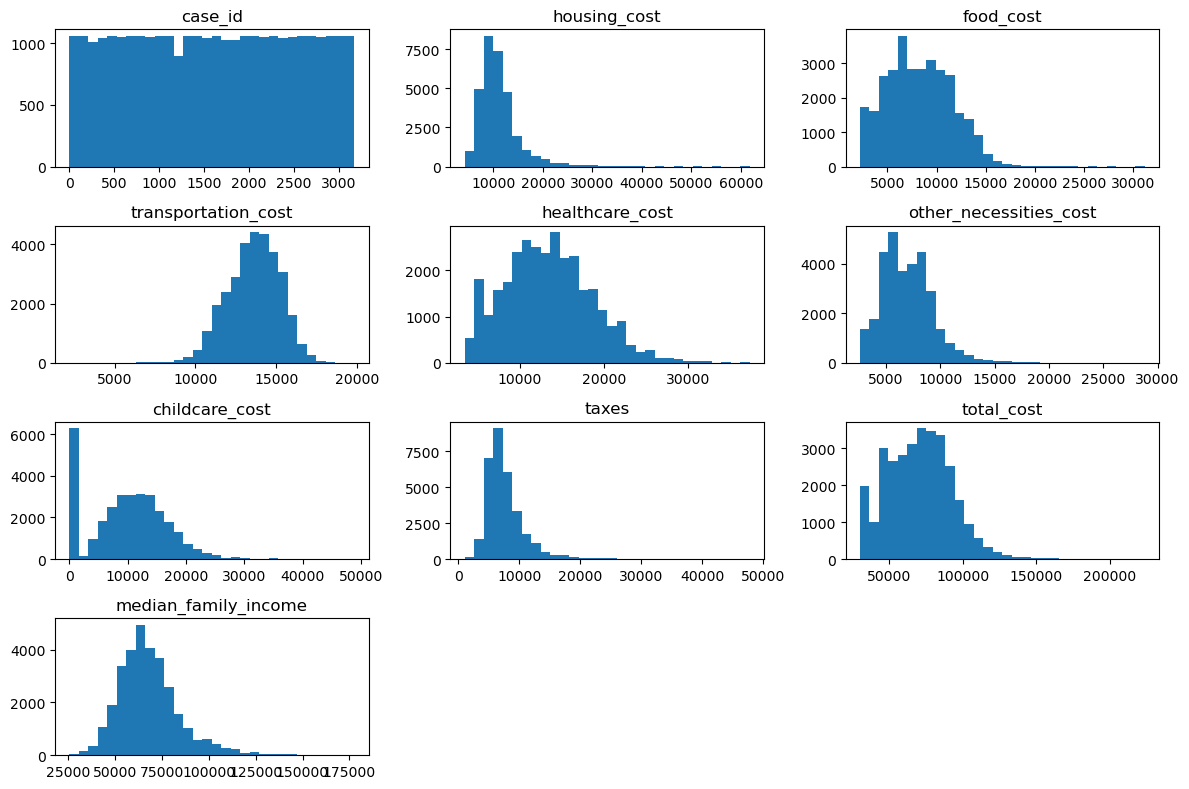

In [11]:
# select numerical columns
num_cols = cost_of_living.select_dtypes(include=['number']).columns

# plot histograms for numerical features
cost_of_living[num_cols].hist(figsize=(12,8), bins=30, grid=False)
plt.tight_layout()
plt.show()

# plot boxplots for numerical features
#plt.figure(figsize=(12,6))
#sns.boxplot(data=cost_of_living[num_cols])
#plt.xticks(rotation=45)  # Rotate labels for better readability
#plt.show()

Note:
- case_id is uniformly spread, which indicates that there is an even spread for each distinct area name
- Many variables follow a right skewed distribution: housing_cost, food_cost, healthcare_cost, other_necessities_cost, childcare_cost, taxes, and total cost.
- median_family_income is slightly right skewed.
- transportation_cost is slightly left skewed.
- There is visual evidence of outliers.

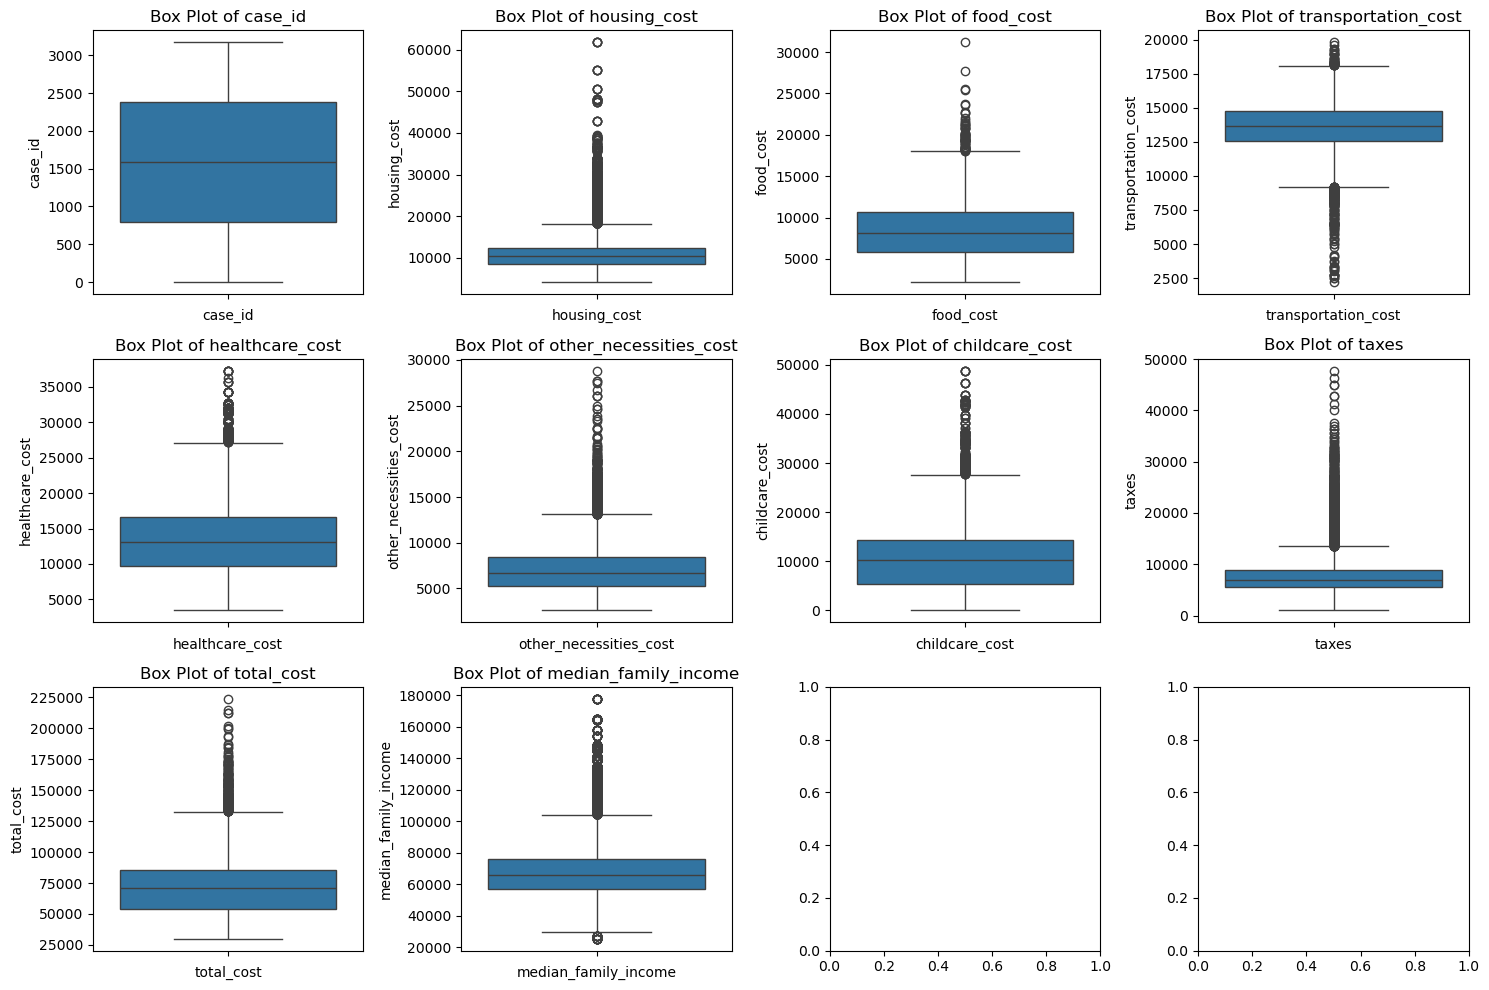

In [12]:
# subplots set up
rows = 3
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 10)) 
axes = axes.flatten()


#boxplot
#iterate through each numerical variable
i = 0
for var in num_cols:
    #create boxplot for current variable
    sns.boxplot(y=cost_of_living[var], ax = axes[i])
    #add title with variable name
    axes[i].set_title(f'Box Plot of {var}')
    #label x-axis with variable name
    axes[i].set_xlabel(var)
    i += 1
    
# Adjust layout
plt.tight_layout()
plt.show()

The boxplots show a large number of outliers.

In [13]:
#define function to identify outliers via IQR
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

#create dataframe to store outliers
outliers_df = pd.DataFrame()

#apply function to numerical variables
#iterate over variables
for var in num_cols:
    outliers = identify_outliers(cost_of_living, var)
    #concatenate outliers to outlier dataframe
    outliers_df = pd.concat([outliers_df, outliers])

#drop duplicate rows since some rows may be outliers in multiple columns
outliers_df = outliers_df.drop_duplicates()

#display the outliers
outliers_df.shape

(3113, 15)

In [14]:
3113/31420

0.09907702100572884

About 9.9% of the instances contain outliers.

In [15]:
# count metro vs non-metro outliers
outliers_df['isMetro'].value_counts()

True     2376
False     737
Name: isMetro, dtype: int64

In [16]:
cost_of_living['isMetro'].value_counts()

False    19730
True     11690
Name: isMetro, dtype: int64

- We can see that most of the outliers occur in metro areas. This makes sense considering metro areas tend to have significantly higher costs than non-metro areas.
- 737 instances are from non-metro areas where costs may be unexpectedly high. This could potentially be from counties with unique economic conditions.

Methods to handle these outliers are capping, transformation, or removal. For this project, outliers will be handled via capping. This will preserve all data points while reducing extreme influence and doesn't negatively impact interpretability.
- Note: can distort real economic trends if thresholds are too strict, choosing the right threshold is subjective, may not fully resolve skewness.

In [17]:
# Define a function to cap outliers
def cap_outliers(data, column, lower_pct=0.05, upper_pct=0.95):
    data[column] = winsorize(data[column], limits=(lower_pct, 1-upper_pct))
    return data

# Apply the function to all numerical columns
for var in num_cols:
    col_clean = cap_outliers(cost_of_living, var)

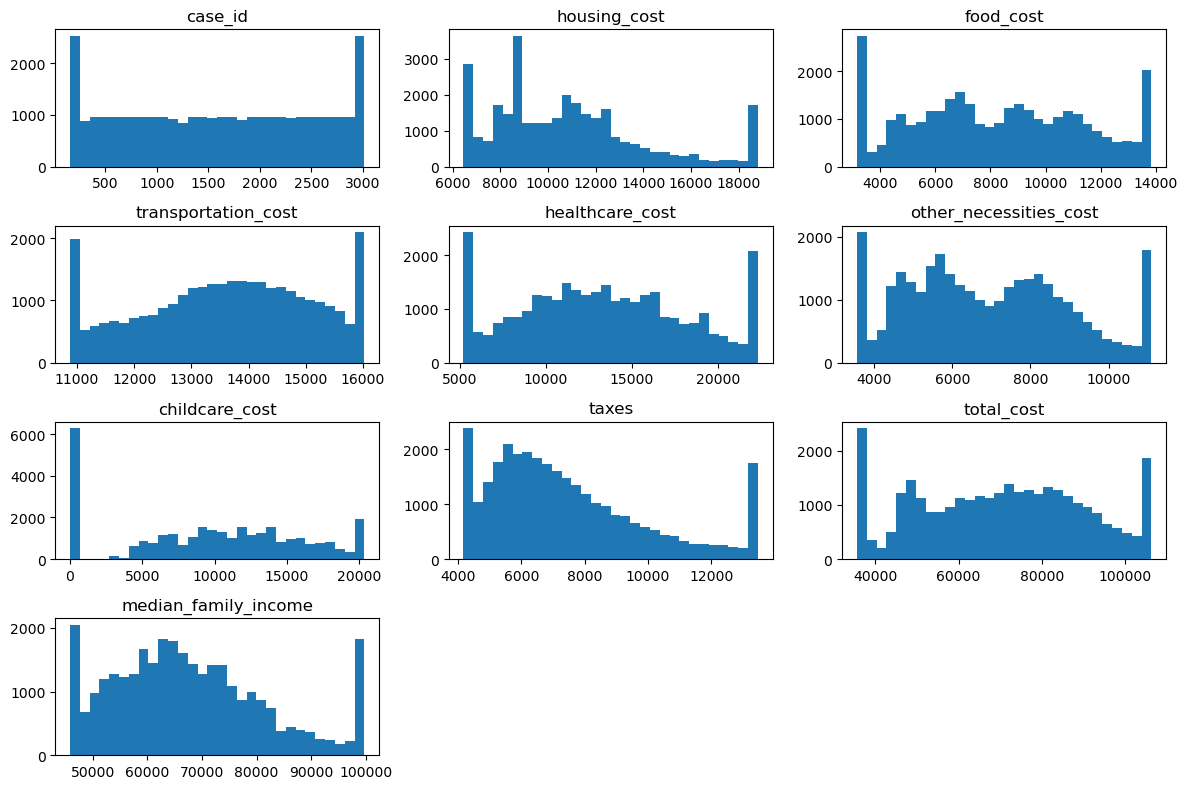

In [18]:
# select numerical columns
num_cols = col_clean.select_dtypes(include=['number']).columns

# plot histograms for numerical features
col_clean[num_cols].hist(figsize=(12,8), bins=30, grid=False)
plt.tight_layout()
plt.show()

# Cleaning Columns

The next step is to clean up to columns. Towards the beginning I made some notes:
- Didn't like how family_member_count was set up. This will be split into three new variables (num_parents, num_children, and family_total) and then family_member_count will be dropped.
- Noticed that case_id and areaname served the same purpose. case_id will be dropped in favor of areaname

In [19]:
# Function to extract parent and child counts
def extract_family_counts(family_str):
    if isinstance(family_str, str):  # Ensure the input is a string
        match = re.match(r'(\d+)p(\d+)c', family_str)  # Regex to extract numbers before 'p' and 'c'
        if match:
            num_parents = int(match.group(1))  # Extract parent count
            num_children = int(match.group(2))  # Extract child count
        else:
            num_parents, num_children = 0, 0  # Default for unexpected formats
    else:
        num_parents, num_children = 0, 0  # Handle non-string cases safely

    return num_parents, num_children

# Ensure 'family_member_count' is a string before applying the function
col_clean['family_member_count'] = col_clean['family_member_count'].astype(str)

# Apply function to create new columns
col_clean[['num_parents', 'num_children']] = col_clean['family_member_count'].apply(lambda x: pd.Series(extract_family_counts(x)))

# Create total family size column
col_clean['family_total'] = col_clean['num_parents'] + col_clean['num_children']

# Drop case_id and family_member_count columns
col_clean = col_clean.drop(columns=['case_id', 'family_member_count'])

# Verify changes
col_clean.head()

,state,isMetro,areaname,county,housing_cost,food_cost,transportation_cost,healthcare_cost,other_necessities_cost,childcare_cost,taxes,total_cost,median_family_income,num_parents,num_children,family_total
0,AL,True,"Montgomery, AL MSA",Autauga County,8505.72876,3454.91712,10876.68600,5737.47984,4333.81344,0.0000,6392.94504,39254.0532,73010.414062,1,0,1
1,AL,True,"Montgomery, AL MSA",Autauga County,12067.50240,5091.70788,11588.19288,8659.55640,6217.45896,6147.8298,7422.07836,57194.3256,73010.414062,1,1,2
2,AL,True,"Montgomery, AL MSA",Autauga County,12067.50240,7460.20308,12361.77720,11581.63260,7075.65816,15824.6940,9769.56228,76141.0308,73010.414062,1,2,3
3,AL,True,"Montgomery, AL MSA",Autauga County,15257.15040,9952.23924,13452.18600,14503.70760,9134.35620,18802.1892,13101.70320,94203.5328,73010.414062,1,3,4
4,AL,True,"Montgomery, AL MSA",Autauga County,15257.15040,12182.21400,13744.59840,17425.78560,9942.36396,18802.1892,13464.39120,100823.5200,73010.414062,1,4,5


In [20]:
col_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31420 entries, 0 to 31429
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   state                   31420 non-null  category
 1   isMetro                 31420 non-null  bool    
 2   areaname                31420 non-null  category
 3   county                  31420 non-null  category
 4   housing_cost            31420 non-null  float64 
 5   food_cost               31420 non-null  float64 
 6   transportation_cost     31420 non-null  float64 
 7   healthcare_cost         31420 non-null  float64 
 8   other_necessities_cost  31420 non-null  float64 
 9   childcare_cost          31420 non-null  float64 
 10  taxes                   31420 non-null  float64 
 11  total_cost              31420 non-null  float64 
 12  median_family_income    31420 non-null  float64 
 13  num_parents             31420 non-null  int64   
 14  num_children          

Now that the dataset has been cleaned, time to move on to explore trends and correlations.